#A REVIEW OF SPARSE EXPERT MODELS IN DEEP LEARNING
##The Sparsely-Gated Mixture-of-Experts Layer

###INTRODUCTION  
Sparse expert models, of which Mixture-of-Experts (MoE) is the most popular variant, are a thirty-year old concept re-emerging as a popular architecture in deep learning. They are neural networks where a set of the parameters are partitioned into “experts”, each with a unique weight. During training and inference, the models route input examples to specific expert(s) weights. As a result, each example only interacts with a subset of the network parameters (contrasting the usual approach where the entire network is used for each input), keeping the amount of computation small relative to the total model size, and allowing for extremely large, but efficient models.
In early concepts (Jacobs et al. ,1991), the experts defined an entire neural network and the MoE was similar to ensemble methods. However, later and more efficient implementations relied on the idea of MoE as a component of a neural network.
###OUR APPROACH: THE SPARSELY-GATED MIXTURE-OF-EXPERTS LAYER
Our approach to increase model capacity without a proportional increase in computational costs is to introduce a general purpose neural network component: the Sparsely-Gated Mixture-of-Experts Layer (MoE).
It consists of a set of n “expert networks", each a simple convolutional neural network, and a trainable “gating network”,  which selects a sparse combination of the experts to process each input and whose output is a sparse n-dimensional vector.
Let us denote by G(x) and Ei(x) the output of the gating network and the output of the i-th expert network for a given input x, the output y of the MoE module can be written as:  
 y =∑G(x)iEi(x)
We save computation based on the sparsity of the output of G(x); wherever G(x)i = 0, we do not need to compute Ei(x).

###ROUTING ALGORITHMS
The routing algorithm is a key feature to all sparse expert architectures, determining where to send examples. Typically the naive routing decision is non-differentiable, because it makes a discrete decision of which experts to select. Shazeer et al. (2017) proposed a differentiable heuristic: the output of the expert computation is weighted by the probability of choosing it and this produces a gradient to the router.
GATING NETWORK
Softmax Gating: A simple choice of non-sparse gating function (Jordan & Jacobs, 1994) is to multiply the input by a trainable weight matrix Wg and then apply the Softmax function. G(x) = Softmax(x · Wg )
Noisy Top-K Gating: We add two components to the Softmax gating network: sparsity and noise. Before taking the softmax function, we add tunable Gaussian noise, then keep only the top k values, setting the rest to −∞ (which causes the corresponding gate values to equal 0). The noise term helps with load balancing. The amount of noise per component is controlled by a second trainable weight matrix.
Balancing expert utilization: we have observed that the gating network tends to converge to a state where it always produces large weights for the same few experts. So, we defined the importance of an expert relative to a batch of training examples to be the batch-wise sum of the gate values for that expert, and an additional loss which is added to the overall loss function of the model. This loss is equal to the square of the coefficient of variation of the set of importance values, multiplied by a hand-tuned scaling factor, and encourages all experts to have equal importance. Nevertheless, experts may still receive very different numbers of examples. For example, one expert may receive a few examples with large weights, and another may receive many examples with small weights.
We trained the gating network by simple back-propagation, along with the rest of the model.
###CONCLUSIONS
Sparsity reduces the training and inference costs, resulting in massive models with a better accuracy than their dense counterparts.
Furthermore, sparse expert models more naturally lend themselves to interpretability studies because each input is processed by an identifiable, discrete subset of the model weights (the chosen experts).





#Import

In [ ]:
import time
from PIL import Image
import os
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms as T
from torch.optim import Adam
import tqdm
import matplotlib.pyplot as plt
from torch.distributions.normal import Normal
import numpy as np
import math
from inspect import isfunction
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED) # Best effort to be reproducible. If there are nondeterministic operations like some cnn kernels you have different results even with the same seed.
torch.backends.cudnn.deterministic = True  # Uses deterministic operations when possible, otherwise raises an error

#Load_Data

In [ ]:
train_data = torchvision.datasets.CIFAR10(root='data', train = True, download = True)


100%|██████████| 170498071/170498071 [00:13<00:00, 12730525.42it/s]


Extracting data/cifar-10-python.tar.gz to data


In [ ]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train

In [ ]:
for input in train_data:
  x=input[0]
  y=input[1]
  break

In [ ]:
input

(<PIL.Image.Image image mode=RGB size=32x32>, 6)

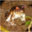

In [ ]:
x

In [ ]:
print(x)
type(x)

<PIL.Image.Image image mode=RGB size=32x32 at 0x7F6A593236D0>


PIL.Image.Image

In [ ]:
print(y)
type(y)

6


int

In [ ]:
train_transforms= T.Compose([T.RandomRotation(15),
                             T.RandomHorizontalFlip(0.15),
                             T.RandomVerticalFlip(0.15),
                             T.ToTensor()])

train_data = torchvision.datasets.CIFAR10('data', train = True, transform = train_transforms)

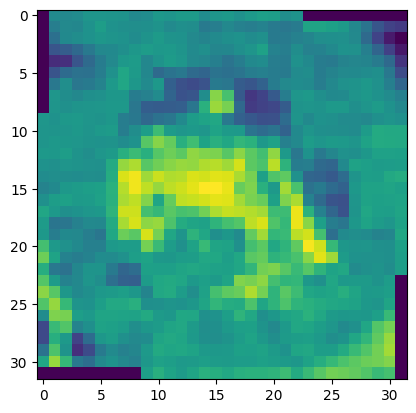

In [ ]:
for x,y in train_data:
  plt.imshow(x.numpy()[0])
  break

In [ ]:
x

tensor([[[0.0000, 0.4784, 0.4667,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.4275, 0.4706,  ..., 0.2667, 0.1961, 0.1686],
         [0.0000, 0.3686, 0.4745,  ..., 0.2000, 0.0706, 0.0000],
         ...,
         [0.3804, 0.7216, 0.5137,  ..., 0.7882, 0.8627, 0.0000],
         [0.5922, 0.8471, 0.6667,  ..., 0.7882, 0.8157, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.6784, 0.7059, 0.0000]],

        [[0.0000, 0.3412, 0.3255,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.2863, 0.3294,  ..., 0.2118, 0.1882, 0.1804],
         [0.0000, 0.2431, 0.3333,  ..., 0.1059, 0.0314, 0.0000],
         ...,
         [0.2431, 0.5804, 0.3686,  ..., 0.5882, 0.7137, 0.0000],
         [0.4627, 0.7216, 0.5490,  ..., 0.6000, 0.6667, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.4824, 0.5451, 0.0000]],

        [[0.0000, 0.2235, 0.1961,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.1647, 0.1961,  ..., 0.1647, 0.1686, 0.1765],
         [0.0000, 0.1373, 0.1882,  ..., 0.0314, 0.0000, 0.

In [ ]:
x.shape

torch.Size([3, 32, 32])

In [ ]:
print(type(x))
print(type(y))

<class 'torch.Tensor'>
<class 'int'>


In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)

In [ ]:
transform2 =T.ToTensor()
test_data = torchvision.datasets.CIFAR10('data', train = False, transform = transform2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 64, shuffle=False)
print(len(test_data))
print(len(test_loader))

10000
157


torch.Size([64, 3, 32, 32])
torch.Size([64])
tensor([0, 9, 9, 1, 6, 0, 2, 0, 6, 5, 5, 0, 3, 4, 6, 8, 9, 7, 6, 3, 7, 3, 2, 7,
        7, 8, 8, 4, 5, 0, 5, 4, 2, 7, 5, 9, 4, 0, 6, 9, 9, 9, 4, 2, 7, 0, 0, 5,
        2, 4, 5, 5, 1, 7, 0, 4, 6, 0, 1, 1, 3, 7, 5, 2])


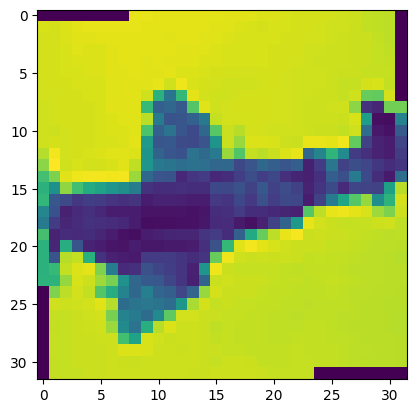

In [ ]:
for data in train_loader:
  x_load=data[0]
  y_load=data[1]

  print(x_load.shape)
  print(y_load.shape)
  print(y_load)
  plt.imshow(x_load[0,0].numpy())
  break

#Model

###Expert





In [ ]:
class Expert(nn.Module):
    def __init__(self):
        super(Expert, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.bn1 = nn.BatchNorm2d(8)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, 5)
        self.bn2 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16* 5 * 5, 512)
        self.drop1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(512, 256)
        self.drop2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = x.view(-1, 16 * 5 * 5)
        x = self.drop1(F.relu(self.fc1(x)))
        x = self.drop2(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x


### MoE


In [ ]:
class SparseDispatcher(object):
    """Helper for implementing a mixture of experts.
    The purpose of this class is to create input minibatches for the
    experts and to combine the results of the experts to form a unified
    output tensor.
    There are two functions:
    dispatch - takes an input Tensor and creates input Tensors for each expert.
    combine - takes output Tensors from each expert and forms a combined output
      Tensor.  Outputs from different experts for the same batch element are
      summed together, weighted by the provided "gates".
    The class is initialized with a "gates" Tensor, which specifies which
    batch elements go to which experts, and the weights to use when combining
    the outputs.  Batch element b is sent to expert e iff gates[b, e] != 0.
    The inputs and outputs are all two-dimensional [batch, depth].
    Caller is responsible for collapsing additional dimensions prior to
    calling this class and reshaping the output to the original shape.
    See common_layers.reshape_like().
    Example use:
    gates: a float32 `Tensor` with shape `[batch_size, num_experts]`
    inputs: a float32 `Tensor` with shape `[batch_size, input_size]`
    experts: a list of length `num_experts` containing sub-networks.
    dispatcher = SparseDispatcher(num_experts, gates)
    expert_inputs = dispatcher.dispatch(inputs)
    expert_outputs = [experts[i](expert_inputs[i]) for i in range(num_experts)]
    outputs = dispatcher.combine(expert_outputs)
    The preceding code sets the output for a particular example b to:
    output[b] = Sum_i(gates[b, i] * experts[i](inputs[b]))
    This class takes advantage of sparsity in the gate matrix by including in the
    `Tensor`s for expert i only the batch elements for which `gates[b, i] > 0`.
    """
    def __init__(self, num_experts, gates):
        self._gates = gates
        self._num_experts = num_experts
        # sort experts
        sorted_experts, index_sorted_experts = torch.nonzero(gates).sort(0)
        # drop indices
        _, self._expert_index = sorted_experts.split(1, dim=1)
        # get according batch index for each expert
        self._batch_index = torch.nonzero(gates)[index_sorted_experts[:, 1], 0]
        # calculate num samples that each expert gets
        self._part_sizes = (gates > 0).sum(0).tolist()
        # expand gates to match with self._batch_index
        gates_exp = gates[self._batch_index.flatten()]
        self._nonzero_gates = torch.gather(gates_exp, 1, self._expert_index)

    def dispatch(self, inp):
      """Create one input Tensor for each expert.
        The `Tensor` for a expert `i` contains the slices of `inp` corresponding
        to the batch elements `b` where `gates[b, i] > 0`.
        Args:
          inp: a `Tensor` of shape "[batch_size, <extra_input_dims>]`
        Returns: a list of `num_experts` `Tensor`s with shapes
            `[expert_batch_size_i, <extra_input_dims>]`.
        """
        # assigns samples to experts whose gate is nonzero
        # expand according to batch index so we can just split by _part_sizes
      inp_exp = inp[self._batch_index].squeeze(1)
      return torch.split(inp_exp, self._part_sizes, dim=0)

    def combine(self, expert_out, multiply_by_gates=True):
      """Sum together the expert output, weighted by the gates.
        The slice corresponding to a particular batch element `b` is computed
        as the sum over all experts `i` of the expert output, weighted by the
        corresponding gate values.  If `multiply_by_gates` is set to False, the
        gate values are ignored.
        Args:
          expert_out: a list of `num_experts` `Tensor`s, each with shape
            `[expert_batch_size_i, <extra_output_dims>]`.
          multiply_by_gates: a boolean
        Returns: a `Tensor` with shape `[batch_size, <extra_output_dims>]`.
        """
      # apply exp to expert outputs, so we are not longer in log space
      stitched = torch.cat(expert_out, 0)

      if multiply_by_gates:
          stitched = stitched.mul(self._nonzero_gates)
      zeros = torch.zeros(self._gates.size(0), expert_out[-1].size(1), requires_grad=True, device=stitched.device)
      # combine samples that have been processed by the same k experts
      combined = zeros.index_add(0, self._batch_index, stitched.float())
      return combined

    def expert_to_gates(self):
        """Gate values corresponding to the examples in the per-expert `Tensor`s.
        Returns: a list of `num_experts` one-dimensional `Tensor`s with type `tf.float32`
              and shapes `[expert_batch_size_i]`
        """
        # split nonzero gates for each expert
        return torch.split(self._nonzero_gates, self._part_sizes, dim=0)

In [ ]:
class MoE(nn.Module):

    """Call a Sparsely gated mixture of experts layer with 1-layer Feed-Forward networks as experts.
    Args:
    input_size: integer - size of the input
    output_size: integer - size of the input
    num_experts: an integer - number of experts
    noisy_gating: a boolean
    k: an integer - how many experts to use for each batch element
    """
    def __init__(self, input_size, output_size, num_experts, noisy_gating=True, k=6):
        super(MoE, self).__init__()
        self.noisy_gating = noisy_gating
        self.num_experts = num_experts
        self.output_size = output_size
        self.input_size = input_size
        self.k = k
        input_sizee = list(input_size)
        dim1=input_sizee[0]
        dim2=input_sizee[1]
        dim3=input_sizee[2]

        # instantiate experts
        self.experts = nn.ModuleList([Expert() for i in range(self.num_experts)])
        self.w_gate = nn.Parameter(torch.zeros(dim1*dim2*dim3, num_experts), requires_grad=True)
        self.w_noise = nn.Parameter(torch.zeros(dim1*dim2*dim3, num_experts), requires_grad=True)

        self.softplus = nn.Softplus()
        self.softmax = nn.Softmax(1)
        self.register_buffer("mean", torch.tensor([0.0]))
        self.register_buffer("std", torch.tensor([1.0]))
        assert(self.k <= self.num_experts)


    def noisy_top_k_gating(self, x, train, noise_epsilon=1e-2):
        """Noisy top-k gating.
          See paper: https://arxiv.org/abs/1701.06538.
          Args:
            x: input Tensor with shape [batch_size, input_size]
            train: a boolean - we only add noise at training time.
            noise_epsilon: a float
          Returns:
            gates: a Tensor with shape [batch_size, num_experts]
            load: a Tensor with shape [num_experts]t
        """
        x2 = x.view(x.size(0), -1)
        clean_logits = x2 @ self.w_gate

        if self.noisy_gating and train:
            raw_noise_stddev = x2 @ self.w_noise
            noise_stddev = ((self.softplus(raw_noise_stddev) + noise_epsilon))
            noisy_logits = clean_logits + (torch.randn_like(clean_logits) * noise_stddev)
            logits = noisy_logits
        else:
            logits = clean_logits

        # calculate topk + 1 that will be needed for the noisy gates
        top_logits, top_indices = logits.topk(min(self.k + 1, self.num_experts), dim=1)
        top_k_logits = top_logits[:, :self.k]
        top_k_indices = top_indices[:, :self.k]
        top_k_gates = self.softmax(top_k_logits)

        zeros = torch.zeros_like(logits, requires_grad=True)
        gates = zeros.scatter(1, top_k_indices, top_k_gates)

        if self.noisy_gating and self.k < self.num_experts and train:
            load = (self._prob_in_top_k(clean_logits, noisy_logits, noise_stddev, top_logits)).sum(0)
        else:
            load = self._gates_to_load(gates)
        return gates, load

    def cv_squared(self, x):
        """The squared coefficient of variation of a sample.
        Useful as a loss to encourage a positive distribution to be more uniform.
        Epsilons added for numerical stability.
        Returns 0 for an empty Tensor.
        Args: x: a `Tensor`.
        Returns: a `Scalar`.
        """
        eps = 1e-10
        # if only num_experts = 1
        if x.shape[0] == 1:
            return torch.tensor([0], device=x.device, dtype=x.dtype)
        return x.float().var() / (x.float().mean()**2 + eps)

    def _gates_to_load(self, gates):
        """Compute the true load per expert, given the gates.
        The load is the number of examples for which the corresponding gate is >0.
        Args: gates: a `Tensor` of shape [batch_size, n]
        Returns: a float32 `Tensor` of shape [n]
        """
        return (gates > 0).sum(0)

    def _prob_in_top_k(self, clean_values, noisy_values, noise_stddev, noisy_top_values):
        """Helper function to NoisyTopKGating.
        Computes the probability that value is in top k, given different random noise.
        This gives us a way of backpropagating from a loss that balances the number
        of times each expert is in the top k experts per example.
        In the case of no noise, pass in None for noise_stddev, and the result will
        not be differentiable.
        Args:
        clean_values: a `Tensor` of shape [batch, n].
        noisy_values: a `Tensor` of shape [batch, n].  Equal to clean values plus
          normally distributed noise with standard deviation noise_stddev.
        noise_stddev: a `Tensor` of shape [batch, n], or None
        noisy_top_values: a `Tensor` of shape [batch, m].
           "values" Output of tf.top_k(noisy_top_values, m).  m >= k+1
        Returns: a `Tensor` of shape [batch, n].
        """
        batch = clean_values.size(0)
        m = noisy_top_values.size(1)
        top_values_flat = noisy_top_values.flatten()

        threshold_positions_if_in = torch.arange(batch, device=clean_values.device) * m + self.k
        threshold_if_in = torch.unsqueeze(torch.gather(top_values_flat, 0, threshold_positions_if_in), 1)
        is_in = torch.gt(noisy_values, threshold_if_in)
        threshold_positions_if_out = threshold_positions_if_in - 1
        threshold_if_out = torch.unsqueeze(torch.gather(top_values_flat, 0, threshold_positions_if_out), 1)
        # is each value currently in the top k.
        normal = Normal(self.mean, self.std)
        prob_if_in = normal.cdf((clean_values - threshold_if_in)/noise_stddev)
        prob_if_out = normal.cdf((clean_values - threshold_if_out)/noise_stddev)
        prob = torch.where(is_in, prob_if_in, prob_if_out)
        return prob

    def forward(self, x, loss_coef=1e-2):
        """Args:
        x: tensor shape [batch_size, input_size]
        train: a boolean scalar.
        loss_coef: a scalar - multiplier on load-balancing losses
        Returns:
        y: a tensor with shape [batch_size, output_size].
        extra_training_loss: a scalar.  This should be added into the overall
        training loss of the model.  The backpropagation of this loss
        encourages all experts to be approximately equally used across a batch.
        """
        gates, load = self.noisy_top_k_gating(x, self.training)

        # calculate importance loss
        importance = gates.sum(0)

        loss = self.cv_squared(importance) + self.cv_squared(load)
        loss *= loss_coef

        dispatcher = SparseDispatcher(self.num_experts, gates)
        expert_inputs = dispatcher.dispatch(x)
        gates = dispatcher.expert_to_gates()
        expert_outputs = [self.experts[i](expert_inputs[i]) for i in range(self.num_experts)]
        y = dispatcher.combine(expert_outputs)
        return y, loss

#Train&Test

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

Epoch 1/40, Train Loss: 1.6139, Test Accuracy: 41.47%, Time per epoch: 163.55 seconds
Epoch 2/40, Train Loss: 1.3869, Test Accuracy: 48.83%, Time per epoch: 177.88 seconds
Epoch 3/40, Train Loss: 1.2983, Test Accuracy: 55.54%, Time per epoch: 178.62 seconds
Epoch 4/40, Train Loss: 1.2067, Test Accuracy: 57.91%, Time per epoch: 181.67 seconds
Epoch 5/40, Train Loss: 1.1527, Test Accuracy: 62.90%, Time per epoch: 183.11 seconds
Epoch 6/40, Train Loss: 1.1150, Test Accuracy: 57.91%, Time per epoch: 185.91 seconds
Epoch 7/40, Train Loss: 1.0827, Test Accuracy: 63.15%, Time per epoch: 189.52 seconds
Epoch 8/40, Train Loss: 1.0462, Test Accuracy: 65.73%, Time per epoch: 190.82 seconds
Epoch 9/40, Train Loss: 1.0338, Test Accuracy: 63.49%, Time per epoch: 193.98 seconds
Epoch 10/40, Train Loss: 1.0115, Test Accuracy: 60.70%, Time per epoch: 223.15 seconds
Epoch 11/40, Train Loss: 0.9885, Test Accuracy: 61.42%, Time per epoch: 257.05 seconds
Epoch 12/40, Train Loss: 0.9718, Test Accuracy: 61.1

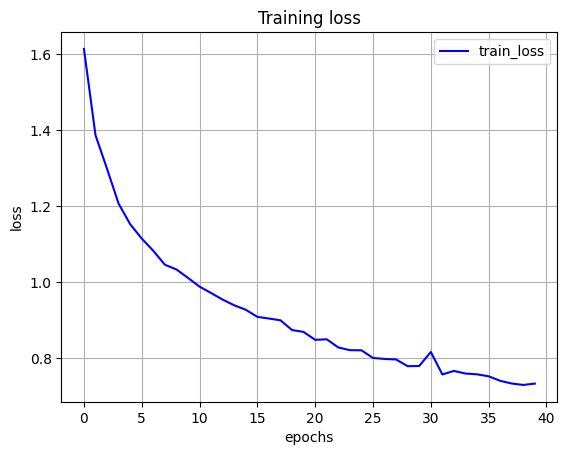

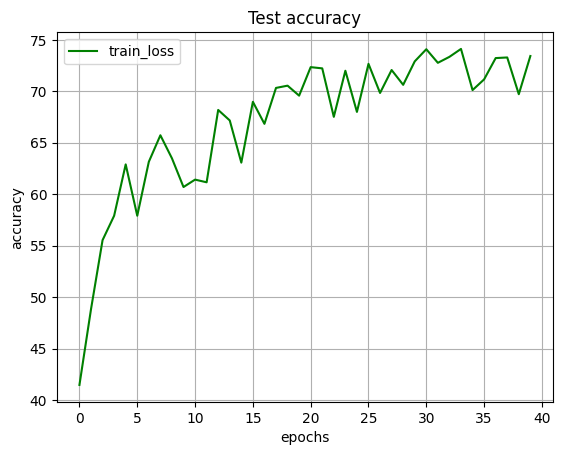

In [ ]:
net = MoE((3, 32, 32), output_size=10, num_experts=10, noisy_gating=True, k=6)
net = net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
num_epochs = 40

train_loss_list106= []
test_acc_list106 = []

for epoch in range(num_epochs):
    train_loss = 0.0
    start_time = time.time()
    net.train()
    for i, data in enumerate(train_loader,0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()  #initialize
        outputs, aux_loss = net(inputs)
        loss = criterion(outputs, labels)
        total_loss = loss + aux_loss
        total_loss.backward()
        optimizer.step()
        train_loss+= loss.item()

    correct = 0
    total = 0
    net.eval()
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, _ = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100 * correct / total
    test_acc_list106.append(test_acc)
    end_time = time.time()  #
    epoch_time = end_time - start_time

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/i:.4f}, Test Accuracy: {test_acc:.2f}%, Time per epoch: {epoch_time:.2f} seconds')

    train_loss_list106.append(train_loss/i)

#plot
fig_loss = plt.figure()
plt.plot(range(num_epochs), torch.tensor(train_loss_list106).detach().numpy(), color='blue', linestyle='-', label='train_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Training loss')
plt.grid()

#plot
fig_acc = plt.figure()
plt.plot(range(num_epochs), torch.tensor(test_acc_list106).detach().numpy(), color='green', linestyle='-', label='test_acc')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Test accuracy')
plt.grid()


##not_sparse_MoE

Epoch 1/40, Train Loss: 1.6131, Test Accuracy: 44.29%, Time per epoch: 222.76 seconds
Epoch 2/40, Train Loss: 1.3762, Test Accuracy: 54.16%, Time per epoch: 237.74 seconds
Epoch 3/40, Train Loss: 1.2776, Test Accuracy: 58.28%, Time per epoch: 248.50 seconds
Epoch 4/40, Train Loss: 1.2015, Test Accuracy: 59.74%, Time per epoch: 256.80 seconds
Epoch 5/40, Train Loss: 1.1420, Test Accuracy: 61.05%, Time per epoch: 261.45 seconds
Epoch 6/40, Train Loss: 1.0967, Test Accuracy: 63.09%, Time per epoch: 255.65 seconds
Epoch 7/40, Train Loss: 1.0692, Test Accuracy: 58.37%, Time per epoch: 258.94 seconds
Epoch 8/40, Train Loss: 1.0410, Test Accuracy: 69.22%, Time per epoch: 263.18 seconds
Epoch 9/40, Train Loss: 1.0649, Test Accuracy: 67.04%, Time per epoch: 275.91 seconds
Epoch 10/40, Train Loss: 0.9968, Test Accuracy: 65.75%, Time per epoch: 276.14 seconds
Epoch 11/40, Train Loss: 0.9731, Test Accuracy: 62.43%, Time per epoch: 290.44 seconds
Epoch 12/40, Train Loss: 0.9526, Test Accuracy: 67.4

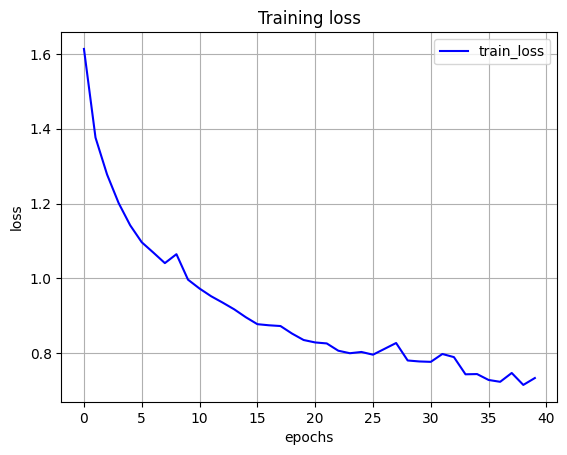

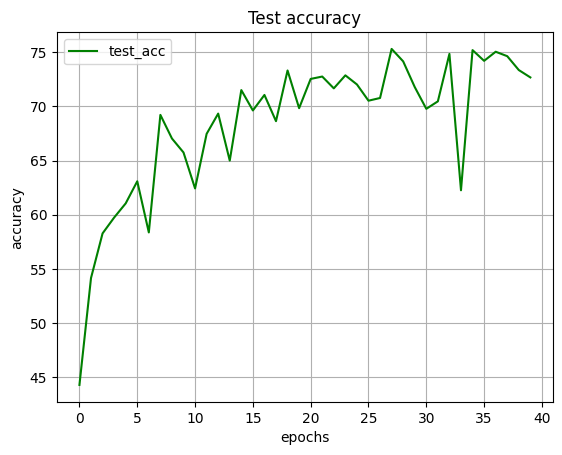

In [ ]:
net = MoE((3, 32, 32), output_size=10, num_experts=10, noisy_gating=True, k=10)
net = net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
num_epochs = 40

train_loss_list1010= []
test_acc_list1010 = []

for epoch in range(num_epochs):
    train_loss = 0.0
    start_time = time.time()
    net.train()
    for i, data in enumerate(train_loader,0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()  #initialize
        outputs, aux_loss = net(inputs)
        loss = criterion(outputs, labels)
        total_loss = loss + aux_loss
        total_loss.backward()
        optimizer.step()
        train_loss+= loss.item()

    correct = 0
    total = 0
    net.eval()  #
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, _ = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100 * correct / total
    test_acc_list1010.append(test_acc)
    end_time = time.time()
    epoch_time = end_time - start_time

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/i:.4f}, Test Accuracy: {test_acc:.2f}%, Time per epoch: {epoch_time:.2f} seconds')

    train_loss_list1010.append(train_loss/i)

#plot
fig_loss = plt.figure()
plt.plot(range(num_epochs), torch.tensor(train_loss_list1010).detach().numpy(), color='blue', linestyle='-', label='train_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Training loss')
plt.grid()

#plot
fig_acc = plt.figure()
plt.plot(range(num_epochs), torch.tensor(test_acc_list1010).detach().numpy(), color='green', linestyle='-', label='test_acc')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Test accuracy')
plt.grid()

## simple_cnn

Epoch 1/40, Train Loss: 1.6030, Test Accuracy: 50.47%
Epoch 2/40, Train Loss: 1.3877, Test Accuracy: 51.45%
Epoch 3/40, Train Loss: 1.3071, Test Accuracy: 50.77%
Epoch 4/40, Train Loss: 1.2569, Test Accuracy: 60.84%
Epoch 5/40, Train Loss: 1.2183, Test Accuracy: 60.25%
Epoch 6/40, Train Loss: 1.1894, Test Accuracy: 59.94%
Epoch 7/40, Train Loss: 1.1604, Test Accuracy: 61.58%
Epoch 8/40, Train Loss: 1.1429, Test Accuracy: 60.56%
Epoch 9/40, Train Loss: 1.1210, Test Accuracy: 61.06%
Epoch 10/40, Train Loss: 1.1059, Test Accuracy: 63.67%
Epoch 11/40, Train Loss: 1.0803, Test Accuracy: 60.72%
Epoch 12/40, Train Loss: 1.0685, Test Accuracy: 65.67%
Epoch 13/40, Train Loss: 1.0614, Test Accuracy: 62.99%
Epoch 14/40, Train Loss: 1.0467, Test Accuracy: 65.13%
Epoch 15/40, Train Loss: 1.0357, Test Accuracy: 66.84%
Epoch 16/40, Train Loss: 1.0258, Test Accuracy: 65.79%
Epoch 17/40, Train Loss: 1.0141, Test Accuracy: 61.25%
Epoch 18/40, Train Loss: 1.0097, Test Accuracy: 66.96%
Epoch 19/40, Train 

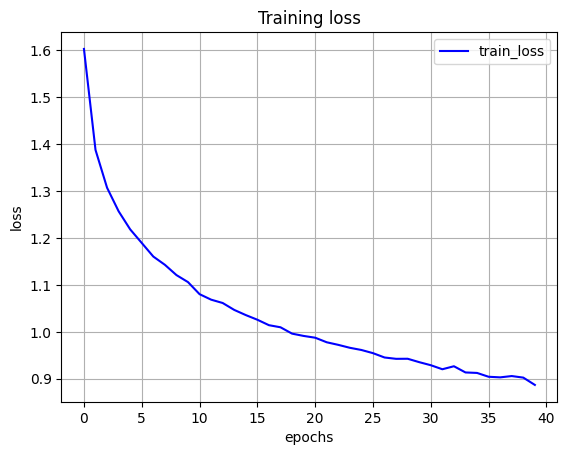

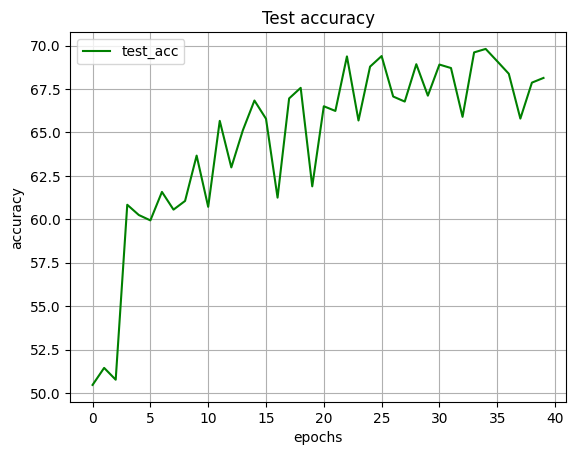

In [ ]:
net = Expert()
net = net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
num_epochs = 40

train_loss_list= []
test_acc_list = []

for epoch in range(num_epochs):
    train_loss = 0.0
    net.train()
    for i, data in enumerate(train_loader,0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        total_loss = loss
        total_loss.backward()
        optimizer.step()
        train_loss+= loss.item()

    correct = 0
    total = 0
    net.eval()
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100 * correct / total
    test_acc_list.append(test_acc)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/i:.4f}, Test Accuracy: {test_acc:.2f}%')
    train_loss_list.append(train_loss/i)

#plot
fig_loss = plt.figure()
plt.plot(range(num_epochs), torch.tensor(train_loss_list).detach().numpy(), color='blue', linestyle='-', label='train_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Training loss')
plt.grid()

#plot
fig_acc = plt.figure()
plt.plot(range(num_epochs), torch.tensor(test_acc_list).detach().numpy(), color='green', linestyle='-', label='test_acc')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Test accuracy')
plt.grid()




# Evaluation




In [ ]:
correct = 0
total = 0
net.eval()
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs, _ = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


Accuracy of the network on the 10000 test images: 75 %


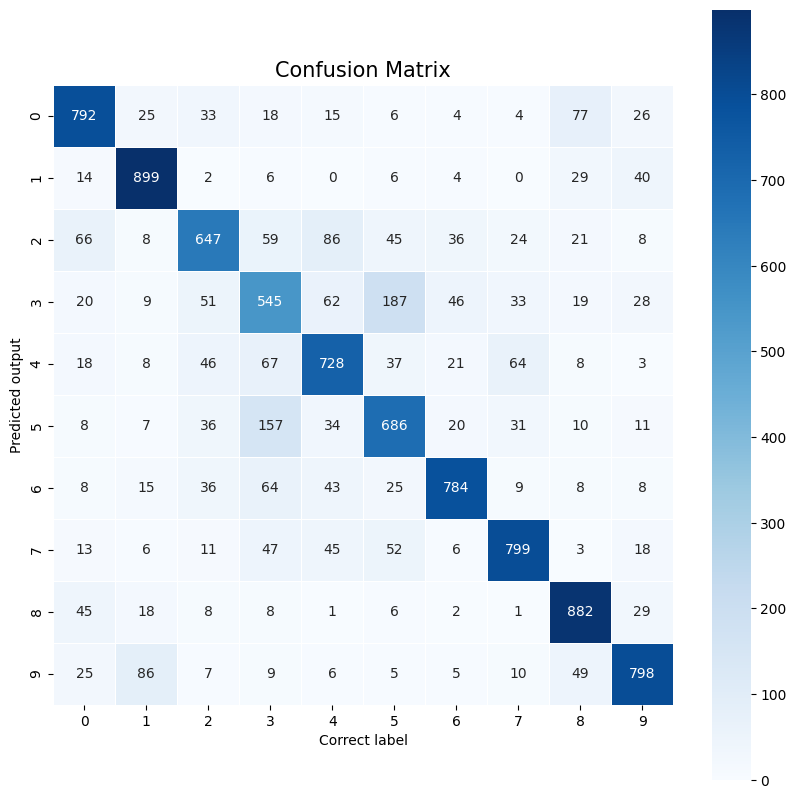

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

net.eval()
all_preds = []
all_labels = []
for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)


    outputs, _ = net(inputs)
    _, predicted = torch.max(outputs.data, 1)

    all_preds.extend(predicted.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues')
plt.ylabel('Predicted output')
plt.xlabel('Correct label')
plt.title('Confusion Matrix', size = 15)
plt.show()


airplane
automobile
bird
cat
deer
dog
frog
horse
ship
truck

#SUMMARY of the main results obtained

3 different nets are proposed in order to compare the results:
* simple_cnn: one single convolutional nn
* not_sparse_MoE: mixture of 10 experts where every batch element is processed by every expert, not using the concept of sparsity (n=10, k=10)
* sparse_MoE: mixture of 10 experts where only 6 of them are used to process each batch element (n=10, k=6)

Next are shown two plots, one for the training loss and one for the test accuracy, in order to compare their evolution during the epochs (red for simple_cnn, green for the dense MoE, blue for the sparse one).

First of all, it is evident that the MoE models overtake (by about 5 points of percentage) the simple-cnn, as it was easily predictable.
What is surprising, instead, is the fact that the dense and the sparse model produce very similar results, but with a significant difference in the computational costs. In fact, for example, we have observed that the time needed for an epoch proportionally increases with the number of experts used for each batch element (about 180 seconds for the sparse model and 300 seconds for the dense one, using cpu).
So it is quite clear that, with equal values of loss and accuracy, it is preferable a model that requires less computational resources.


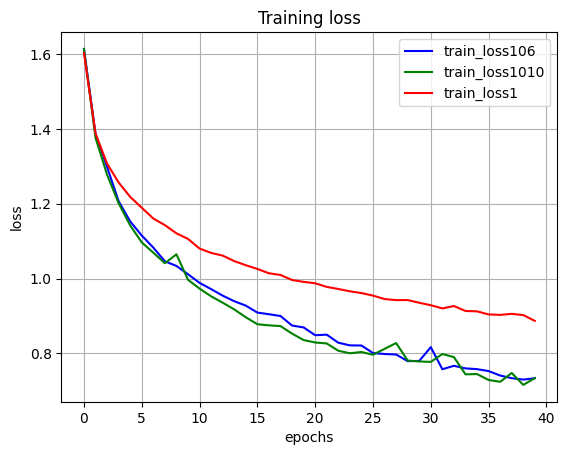

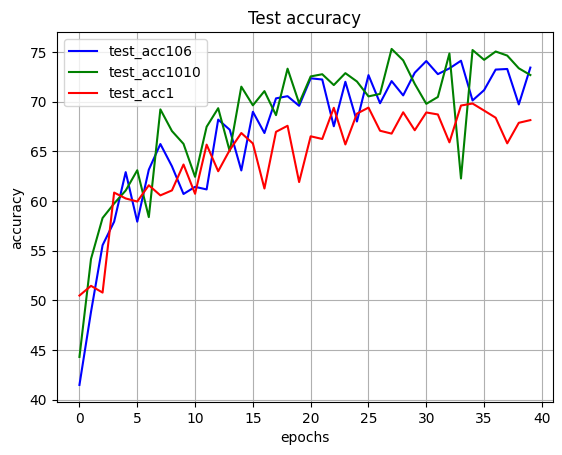

In [ ]:
#plot
fig_loss = plt.figure()
plt.plot(range(num_epochs), torch.tensor(train_loss_list106).detach().numpy(), color='blue', linestyle='-', label='train_loss106')
plt.plot(range(num_epochs), torch.tensor(train_loss_list1010).detach().numpy(), color='green', linestyle='-', label='train_loss1010')
plt.plot(range(num_epochs), torch.tensor(train_loss_list).detach().numpy(), color='red', linestyle='-', label='train_loss1')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Training loss')
plt.grid()

#plot
fig_acc = plt.figure()
plt.plot(range(num_epochs), torch.tensor(test_acc_list106).detach().numpy(), color='blue', linestyle='-', label='test_acc106')
plt.plot(range(num_epochs), torch.tensor(test_acc_list1010).detach().numpy(), color='green', linestyle='-', label='test_acc1010')
plt.plot(range(num_epochs), torch.tensor(test_acc_list).detach().numpy(), color='red', linestyle='-', label='test_acc1')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Test accuracy')
plt.grid()
